In [58]:
import pandas as pd #used for importing
import math as m 
import numpy as np #used for matrix manipulation
from scipy.interpolate import interp2d #used for interpolating Perple_X outputs
from scipy.interpolate import interp1d #used for interpolating evenly spaced P-T conditions from modeling
import colorcet as cc
#import cmcrameri.cm as cmc
import matplotlib.pyplot as plt #plotting package
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap #used for defining user-created colormap
import matplotlib.colors as col

In [59]:
##user input for P-T conditions used in Perplex Calculation. P-T range and nodes used in werami
Tst=273
Tend=1700
Pst=1500
Pend=80000
nodes=250

##user input for initial density and water contents
rho_serp_i=3300     #3150
rho_morb_i=3201.55     #3175
rho_gab_i=3294
rho_sed_i=2650
h2o_serp=.02
h2o_morb=.027533
h2o_gab=0.0079
h2o_sed=.06893
thk_serp=2100
thk_morb=2000 #need to split this into sheeted dikes, lower extrusives, and upper extrusives below
thk_gab=5000
thk_sed=1000

##thickness of layers in the downgoing section. should sum to 10100. The code extracts P-T data every 100m from slabtop
##to 10km below, with each P-T path controlling devolatilization for the underlying 100m, hence the 10km P-T path dictates
##devolatilization in the depth range of 10 to 10.1km
lay_thk=[thk_serp,thk_gab,1400,300,300,thk_sed]

thk_steps=int((sum(lay_thk)-100)/100)
##creates arrays for setting up interpolation, Tmin to tmaxx with an increment matching that used in werami
Tinc=(Tend-Tst)/(nodes-1)
Pinc=(Pend-Pst)/(nodes-1)
Tppx=np.arange(Tst,Tend+Tinc,Tinc)
Pppx=np.arange(Pst,Pend+Pinc,Pinc)

In [60]:
#This section reads in the Holt & Condit dataset and normalizes all ages steps to the same size, from xmin:xmax=500
#this works for all time steps from 1 to 118, it omits the inital step of the calculation.

#create 4 dimensional indexing array
#D1=surface, 5km, 10km
#D2=X,Y,P_lith,P_tot,T
#D3=timestep (1:118)
#D4=nromalized Xdistance=; inc=round((xmax-xmin-1)/500,3); X_new=np.arange(xmin,xmax,inc)==500
idx_len=107 #max ages step included in input file
data_mat_norm=np.zeros((3,5,idx_len,500))

#define naming format
file_slabtop='holt4e20/{}.slabtop.txt'
file_5km='holt4e20/{}.5km.txt'
file_10km='holt4e20/{}.10km.txt'
#file_moho='holt2e20/{}.Moho.txt'

#read in X,Y,P_lith,P_tot,T for each time step
for i in range(8,idx_len+8):
    PT_st=pd.read_csv(file_slabtop.format(i), header=None, delim_whitespace=True)
    PT_5k=pd.read_csv(file_5km.format(i), header=None, delim_whitespace=True)
    PT_10k=pd.read_csv(file_10km.format(i), header=None, delim_whitespace=True)
    #PT_moho=pd.read_csv(file_moho.format(i), header=None, delim_whitespace=True)

    #convert to numpy arrays
    PT_st=PT_st.to_numpy()
    PT_5k=PT_5k.to_numpy()
    PT_10k=PT_10k.to_numpy()
    #PT_moho=PT_moho.to_numpy()

    #flips arrays to be ordered by increasing X
    PT_st=np.flipud(PT_st)
    PT_5k=np.flipud(PT_5k)
    PT_10k=np.flipud(PT_10k)
    #PT_moho=np.flipud(PT_moho)
    
    #determines length of each file for normalization
    mxst=PT_st.shape[0]-1
    mx5k=PT_5k.shape[0]-1
    mx10k=PT_10k.shape[0]-1
    #mxmoho=PT_moho.shape[0]-1

#-----------------------------------------------------------------------------------------------------------------
    xmin=m.ceil(PT_st[1,0]) #determines minimum X value at slabtop
            
    lmax_pos=0 # sets position of max X value for next loop
    
    #this loop iterates through the X data to determine if and where the X value starts appreciably decreasing. 
    #this step is required for interpolation as 1dinterp requires a monotonically increasing independent array
    #the cutoff is set to be where the indexed X-value is greater than the next highest index X-value by a value of 5 
    #value of 5 is somewhat arbitrary.
    
    #IF THIS BLOCK PRESENTS AN ERROR: print(i) AND INSPECT THE FILE TO SEE HOW TO CHANGE THE LOGIC. NOT THE BEST FIX
    #BUT NEEDED DUE TO THE NATURE OF EXTRACTING CONTINUOUS DATA FROM FINITE ELEMENTS.
    
    for j in range(50,mxst):
        if (((PT_st[j,0]>PT_st[j+1,0]) and (PT_st[j,0]-PT_st[j+1,0]>5)) or (PT_st[j,0]-PT_st[j+1,0]<-9)):
            lmax_pos=j
            break  
            
    #if there is no point where the previous loop is satisfied the index for the max X-value is set to the max index 
    #of the array        
    if lmax_pos==0: 
        lmax_pos=mxst
    
    #determines the maximum X value at the previously determined index, and creates the X-range for 1dinterpolation
    xmax=m.floor(PT_st[lmax_pos,0])
    inc=round((xmax-xmin-1)/500,3)
    X_new=np.arange(xmin,xmax,inc)

    #In a few instances the X-range is longer than we want, so we resize by deleting the last few elements.
    if X_new.shape[0]>500:
        X_new=X_new[0:500]
    
    #creates the interpolation functions for Y, P_lith, P_tot, and T as a function of X
    F_Yst=interp1d(PT_st[1:lmax_pos,0],PT_st[1:lmax_pos,1])
    F_Plst=interp1d(PT_st[1:lmax_pos,0],PT_st[1:lmax_pos,2])
    F_Ptst=interp1d(PT_st[1:lmax_pos,0],PT_st[1:lmax_pos,3])
    F_Tst=interp1d(PT_st[1:lmax_pos,0],PT_st[1:lmax_pos,4])
    
    #determines the new values for Y, P_lith, P_tot, and T as a function of the new X-range
    Y_new=F_Yst(X_new)
    Pl_new=F_Plst(X_new)
    Pt_new=F_Ptst(X_new)
    T_new=F_Tst(X_new)
    
    #adds new values of X, Y, P_lith, P_tot, and T to the 4d array. The above section has only computed new values for
    #the slabtop. The next two sections repeat the process for PT conditions at depths of 5 and 10km below the slabtop
    #notice that the indexing shows i-1, this is because we have omitted the first time step from the matrix, it has a bunch
    #of weird artifacts.
    data_mat_norm[0,0,i-8,:]=X_new
    data_mat_norm[0,1,i-8,:]=Y_new
    data_mat_norm[0,2,i-8,:]=Pl_new
    data_mat_norm[0,3,i-8,:]=Pt_new
    data_mat_norm[0,4,i-8,:]=T_new
#----------------------------------------------------------------------------------------------------------------
#5km interpolation    
    xmin=m.ceil(PT_5k[1,0])
            
    lmax_pos=0
    
    for j in range(50,mx5k):
        if (((PT_5k[j,0]>PT_5k[j+1,0]) and (PT_5k[j,0]-PT_5k[j+1,0]>5)) or (PT_5k[j,0]-PT_5k[j+1,0]<-9)):
            lmax_pos=j
            break  
            
    if lmax_pos==0:
        lmax_pos=mx5k
        
    xmax=m.floor(PT_5k[lmax_pos,0])
    inc=round((xmax-xmin-1)/500,3)
    X_new=np.arange(xmin,xmax,inc)

    if X_new.shape[0]>500:
        X_new=X_new[0:500]
    #X_new=X_new[0:490]
    
    F_Y5k=interp1d(PT_5k[1:lmax_pos,0],PT_5k[1:lmax_pos,1])
    F_Pl5k=interp1d(PT_5k[1:lmax_pos,0],PT_5k[1:lmax_pos,2])
    F_Pt5k=interp1d(PT_5k[1:lmax_pos,0],PT_5k[1:lmax_pos,3])
    F_T5k=interp1d(PT_5k[1:lmax_pos,0],PT_5k[1:lmax_pos,4])
    
    Y_new=F_Y5k(X_new)
    Pl_new=F_Pl5k(X_new)
    Pt_new=F_Pt5k(X_new)
    T_new=F_T5k(X_new)
    
    data_mat_norm[1,0,i-8,:]=X_new
    data_mat_norm[1,1,i-8,:]=Y_new
    data_mat_norm[1,2,i-8,:]=Pl_new
    data_mat_norm[1,3,i-8,:]=Pt_new
    data_mat_norm[1,4,i-8,:]=T_new
#----------------------------------------------------------------------------------------------------------------
#10km interpolation
    xmin=m.ceil(PT_10k[1,0])
            
    lmax_pos=0
    
    for j in range(50,mx10k):
        if (((PT_10k[j,0]>PT_10k[j+1,0]) and (PT_10k[j,0]-PT_10k[j+1,0]>5)) or (PT_10k[j,0]-PT_10k[j+1,0]<-9)):
            lmax_pos=j
            break  
            
    if lmax_pos==0:
        lmax_pos=mx10k
        
    xmax=m.floor(PT_10k[lmax_pos,0])
    inc=round((xmax-xmin-1)/500,3)
    X_new=np.arange(xmin,xmax,inc)

    if X_new.shape[0]>500:
        X_new=X_new[0:500]
    #X_new=X_new[0:490]
    
    F_Y10k=interp1d(PT_10k[1:lmax_pos,0],PT_10k[1:lmax_pos,1])
    F_Pl10k=interp1d(PT_10k[1:lmax_pos,0],PT_10k[1:lmax_pos,2])
    F_Pt10k=interp1d(PT_10k[1:lmax_pos,0],PT_10k[1:lmax_pos,3])
    F_T10k=interp1d(PT_10k[1:lmax_pos,0],PT_10k[1:lmax_pos,4])
    
    Y_new=F_Y10k(X_new)
    Pl_new=F_Pl10k(X_new)
    Pt_new=F_Pt10k(X_new)
    T_new=F_T10k(X_new)
    
    data_mat_norm[2,0,i-8,:]=X_new
    data_mat_norm[2,1,i-8,:]=Y_new
    data_mat_norm[2,2,i-8,:]=Pl_new
    data_mat_norm[2,3,i-8,:]=Pt_new
    data_mat_norm[2,4,i-8,:]=T_new

In [61]:
abmin=m.ceil(np.min(data_mat_norm[:,0,:,0])) #absolute minimum of all X-values
abmax=m.floor(np.max(data_mat_norm[:,0,:,499])) #absolute maximum of all X-values
even_inc=abmax-abmin
xrange=np.arange(abmin,abmax) #indexing array used to find start and stop locations for filling D4 of array

In [62]:
##loads in auxillary file which contains ages associated with the time steps. only loads age column
age=pd.read_csv('holt4e20/age_convergence.txt', header=None, usecols=[1], delim_whitespace=True)
age=age.to_numpy()
##creates 2D array of ages for use in contour plotting
age=np.repeat(age[8:idx_len+8],500,axis=1)

convergence=pd.read_csv('holt4e20/age_convergence.txt', header=None, usecols=[2], delim_whitespace=True)
convergence=convergence.to_numpy()
##creates 2D array of convergence rate use in contour plotting
convergence=np.repeat(convergence[8:idx_len+8],even_inc,axis=1)

In [63]:
##This section creates a new 4d array and fills it with even spaced X,Y,P_tot,T data.
##The array is first poulated with NaNs, its maximum dimension encompasses the entire X-range of all P-T paths in 
##1km increments (here 1300). For any given slab the array is populated only over a subset range, with the remaining array
##elements retaining NaN.
## The final results in a 4d array with: 
##D1=X,Y,P_tot,T
##D2=in-slab data, from the interface to 10km depth with a spacing of 100m
##D3=each individual time step from 1 to 118 (0 to 117 as index)
##D4=km spacing over X-range, I have used indexing to fill the final matrix with data interpolated in the loops.

array2=np.empty((4,101,idx_len,even_inc)) #creating of hypercube array
array2[:]=np.nan #filling of array elements with NaN

for k in range(0,idx_len): 
    
    section=data_mat_norm[:,:,k,:]
    min2=m.ceil(np.max(section[:,0,0]))
    max2=m.floor(np.min(section[:,0,499]))
    range2=np.arange(min2,max2)
    
    start=np.where(xrange==min2)[0][0]
    stop=np.where(xrange==max2)[0][0]
    
    FYst=interp1d(section[0,0,:],section[0,1,:])
    FY5k=interp1d(section[1,0,:],section[1,1,:])
    FY10k=interp1d(section[2,0,:],section[2,1,:])
    
    FPst=interp1d(section[0,0,:],section[0,3,:])
    FP5k=interp1d(section[1,0,:],section[1,3,:])
    FP10k=interp1d(section[2,0,:],section[2,3,:])
    
    FTst=interp1d(section[0,0,:],section[0,4,:])
    FT5k=interp1d(section[1,0,:],section[1,4,:])
    FT10k=interp1d(section[2,0,:],section[2,4,:])
    
    Yst=FYst(range2)
    Y5k=FY5k(range2)
    Y10k=FY10k(range2)

    Pst=FPst(range2)
    P5k=FP5k(range2)
    P10k=FP10k(range2)

    Tst=FTst(range2)
    T5k=FT5k(range2)
    T10k=FT10k(range2)
    
    X_incremental=range2.T
    X_incremental=X_incremental.reshape(X_incremental.shape[0],-1)
    X_incremental=np.repeat(X_incremental,101,axis=1)
    array2[0,:,k,start:stop]=X_incremental.T
    
    for l in range(0,101):
        if l<51:
            array2[1,l,k,start:stop]=((1-l/50)*Yst+l/50*Y5k)
            array2[2,l,k,start:stop]=((1-l/50)*Pst+l/50*P5k)
            array2[3,l,k,start:stop]=((1-l/50)*Tst+l/50*T5k)
        else:
            array2[1,l,k,start:stop]=((1-(l-50)/50)*Y5k+(l-50)/50*Y10k)
            array2[2,l,k,start:stop]=((1-(l-50)/50)*P5k+(l-50)/50*P10k)
            array2[3,l,k,start:stop]=((1-(l-50)/50)*T5k+(l-50)/50*T10k)

In [64]:
print(thk_steps) #should be 90 if no sediment, 100 with sediment

100


In [65]:
##read in the werami output files for the layers of interest. In this simple case, we have used 5km of MORB over
##5.1km of serpentinite. The werami output needs to be edited to remove all header info except the final column headers.
##for this simple case the files contain info on rock densisty, fluid density, bound fluid, melt, and melt density
##the first 2 columns of the werami files (corresponding to T and P) are not read in (usecols keyword).
##delim_whitespace is always required for reading in werami files because the spacing between columns is non-uniform.

#lay1=pd.read_csv('holt2e20/gale_morb.tab', usecols=[2,3,4,5,6], delim_whitespace=True)
#lay2=pd.read_csv('holt2e20/hart_peridotite_new.tab', usecols=[2,3,4,5,6], delim_whitespace=True)
#mins=pd.read_csv('holt2e20/morb_minerals_trial.tab', usecols=[2,3,4,5,6,7,8,9,10,11], delim_whitespace=True)

#Below is latest and greatest perple_x outputs
lay0=pd.read_csv('holt2e20/pelagic.tab', usecols=[2,3,4,5,6], delim_whitespace=True)
lay1=pd.read_csv('holt2e20/ue90.tab', usecols=[2,3,4,5,6], delim_whitespace=True)
lay2=pd.read_csv('holt2e20/le90.tab', usecols=[2,3,4,5,6], delim_whitespace=True)
lay3=pd.read_csv('holt2e20/sd90.tab', usecols=[2,3,4,5,6], delim_whitespace=True)
lay4=pd.read_csv('holt2e20/g90.tab', usecols=[2,3,4,5,6], delim_whitespace=True)
lay5=pd.read_csv('holt2e20/hart_peridotite_new.tab', usecols=[2,3,4,5,6], delim_whitespace=True)
wedge=pd.read_csv('wedge_PT/niu_perid_h2o_rho.tab', usecols=[2,3], delim_whitespace=True)
#mins=pd.read_csv('holt2e20/morb_minerals_trial.tab', usecols=[2,3,4,5,6,7,8,9,10,11], delim_whitespace=True)
#mins=pd.read_csv('holt4e20/morb_green_minerals.tab', usecols=[2,3,4,5,6,7,8,9,10,11], delim_whitespace=True)

##convert files to numpy arrays
lay0=lay0.to_numpy()
lay1=lay1.to_numpy()
lay2=lay2.to_numpy()
lay3=lay3.to_numpy()
lay4=lay4.to_numpy()
lay5=lay5.to_numpy()
wedge=wedge.to_numpy()


##repeat the above processes for the other layer/layers read in from Perple_X
lay0_den=lay0[:,0]
lay0_aqden=lay0[:,1]
lay0_fl=lay0[:,2]
lay0_melt=lay0[:,3]
lay0_mden=lay0[:,4]

lay0_den=lay0_den.reshape(nodes,nodes)
lay0_aqden=lay0_aqden.reshape(nodes,nodes)
lay0_fl=lay0_fl.reshape(nodes,nodes)
lay0_melt=lay0_melt.reshape(nodes,nodes)
lay0_mden=lay0_mden.reshape(nodes,nodes)

lay0_den=np.nan_to_num(lay0_den,nan=0)
lay0_aqden=np.nan_to_num(lay0_aqden,nan=0)
lay0_fl=np.nan_to_num(lay0_fl,nan=0)
lay0_melt=np.nan_to_num(lay0_melt,nan=0)
lay0_mden=np.nan_to_num(lay0_mden,nan=0)

F_den_0=interp2d(Tppx,Pppx,lay0_den)
F_aqden_0=interp2d(Tppx,Pppx,lay0_aqden)
F_fl_0=interp2d(Tppx,Pppx,lay0_fl)
F_melt_0=interp2d(Tppx,Pppx,lay0_melt)
F_mden_0=interp2d(Tppx,Pppx,lay0_mden)


##split file into individual properties
lay1_den=lay1[:,0]
lay1_aqden=lay1[:,1]
lay1_fl=lay1[:,2]
lay1_melt=lay1[:,3]
lay1_mden=lay1[:,4]


##reshape individual files onto square grid [node,node]=[250,250] here
lay1_den=lay1_den.reshape(nodes,nodes)
lay1_aqden=lay1_aqden.reshape(nodes,nodes)
lay1_fl=lay1_fl.reshape(nodes,nodes)
lay1_melt=lay1_melt.reshape(nodes,nodes)
lay1_mden=lay1_mden.reshape(nodes,nodes)


##replace NaN with 0. Could be done in perple_X itself as well, but here we do it in post.
lay1_den=np.nan_to_num(lay1_den,nan=0)
lay1_aqden=np.nan_to_num(lay1_aqden,nan=0)
lay1_fl=np.nan_to_num(lay1_fl,nan=0)
lay1_melt=np.nan_to_num(lay1_melt,nan=0)
lay1_mden=np.nan_to_num(lay1_mden,nan=0)

##Create the interpolation functions for density, fluid density, bound H2O, melt, and melt density
F_den_1=interp2d(Tppx,Pppx,lay1_den)
F_aqden_1=interp2d(Tppx,Pppx,lay1_aqden)
F_fl_1=interp2d(Tppx,Pppx,lay1_fl)
F_melt_1=interp2d(Tppx,Pppx,lay1_melt)
F_mden_1=interp2d(Tppx,Pppx,lay1_mden)


##repeat the above processes for the other layer/layers read in from Perple_X
lay2_den=lay2[:,0]
lay2_aqden=lay2[:,1]
lay2_fl=lay2[:,2]
lay2_melt=lay2[:,3]
lay2_mden=lay2[:,4]

lay2_den=lay2_den.reshape(nodes,nodes)
lay2_aqden=lay2_aqden.reshape(nodes,nodes)
lay2_fl=lay2_fl.reshape(nodes,nodes)
lay2_melt=lay2_melt.reshape(nodes,nodes)
lay2_mden=lay2_mden.reshape(nodes,nodes)

lay2_den=np.nan_to_num(lay2_den,nan=0)
lay2_aqden=np.nan_to_num(lay2_aqden,nan=0)
lay2_fl=np.nan_to_num(lay2_fl,nan=0)
lay2_melt=np.nan_to_num(lay2_melt,nan=0)
lay2_mden=np.nan_to_num(lay2_mden,nan=0)

F_den_2=interp2d(Tppx,Pppx,lay2_den)
F_aqden_2=interp2d(Tppx,Pppx,lay2_aqden)
F_fl_2=interp2d(Tppx,Pppx,lay2_fl)
F_melt_2=interp2d(Tppx,Pppx,lay2_melt)
F_mden_2=interp2d(Tppx,Pppx,lay2_mden)

##repeat the above processes for the other layer/layers read in from Perple_X
lay3_den=lay3[:,0]
lay3_aqden=lay3[:,1]
lay3_fl=lay3[:,2]
lay3_melt=lay3[:,3]
lay3_mden=lay3[:,4]

lay3_den=lay3_den.reshape(nodes,nodes)
lay3_aqden=lay3_aqden.reshape(nodes,nodes)
lay3_fl=lay3_fl.reshape(nodes,nodes)
lay3_melt=lay3_melt.reshape(nodes,nodes)
lay3_mden=lay3_mden.reshape(nodes,nodes)

lay3_den=np.nan_to_num(lay3_den,nan=0)
lay3_aqden=np.nan_to_num(lay3_aqden,nan=0)
lay3_fl=np.nan_to_num(lay3_fl,nan=0)
lay3_melt=np.nan_to_num(lay3_melt,nan=0)
lay3_mden=np.nan_to_num(lay3_mden,nan=0)

F_den_3=interp2d(Tppx,Pppx,lay3_den)
F_aqden_3=interp2d(Tppx,Pppx,lay3_aqden)
F_fl_3=interp2d(Tppx,Pppx,lay3_fl)
F_melt_3=interp2d(Tppx,Pppx,lay3_melt)
F_mden_3=interp2d(Tppx,Pppx,lay3_mden)

##repeat the above processes for the other layer/layers read in from Perple_X
lay4_den=lay4[:,0]
lay4_aqden=lay4[:,1]
lay4_fl=lay4[:,2]
lay4_melt=lay4[:,3]
lay4_mden=lay4[:,4]

lay4_den=lay4_den.reshape(nodes,nodes)
lay4_aqden=lay4_aqden.reshape(nodes,nodes)
lay4_fl=lay4_fl.reshape(nodes,nodes)
lay4_melt=lay4_melt.reshape(nodes,nodes)
lay4_mden=lay4_mden.reshape(nodes,nodes)

lay4_den=np.nan_to_num(lay4_den,nan=0)
lay4_aqden=np.nan_to_num(lay4_aqden,nan=0)
lay4_fl=np.nan_to_num(lay4_fl,nan=0)
lay4_melt=np.nan_to_num(lay4_melt,nan=0)
lay4_mden=np.nan_to_num(lay4_mden,nan=0)

F_den_4=interp2d(Tppx,Pppx,lay4_den)
F_aqden_4=interp2d(Tppx,Pppx,lay4_aqden)
F_fl_4=interp2d(Tppx,Pppx,lay4_fl)
F_melt_4=interp2d(Tppx,Pppx,lay4_melt)
F_mden_4=interp2d(Tppx,Pppx,lay4_mden)

##repeat the above processes for the other layer/layers read in from Perple_X
lay5_den=lay5[:,0]
lay5_aqden=lay5[:,1]
lay5_fl=lay5[:,2]
lay5_melt=lay5[:,3]
lay5_mden=lay5[:,4]

lay5_den=lay5_den.reshape(nodes,nodes)
lay5_aqden=lay5_aqden.reshape(nodes,nodes)
lay5_fl=lay5_fl.reshape(nodes,nodes)
lay5_melt=lay5_melt.reshape(nodes,nodes)
lay5_mden=lay5_mden.reshape(nodes,nodes)

lay5_den=np.nan_to_num(lay5_den,nan=0)
lay5_aqden=np.nan_to_num(lay5_aqden,nan=0)
lay5_fl=np.nan_to_num(lay5_fl,nan=0)
lay5_melt=np.nan_to_num(lay5_melt,nan=0)
lay5_mden=np.nan_to_num(lay5_mden,nan=0)

F_den_5=interp2d(Tppx,Pppx,lay5_den)
F_aqden_5=interp2d(Tppx,Pppx,lay5_aqden)
F_fl_5=interp2d(Tppx,Pppx,lay5_fl)
F_melt_5=interp2d(Tppx,Pppx,lay5_melt)
F_mden_5=interp2d(Tppx,Pppx,lay5_mden)

##setup wedge interpolation, simplified from others, only care about H2O
wedge_fl=wedge[:,0]
wedge_fl=wedge_fl.reshape(nodes,nodes)
wedge_fl=np.nan_to_num(wedge_fl,nan=0)
F_fl_wedge=interp2d(Tppx,Pppx,wedge_fl)

##Define where interpolation will switch from one layer to the next
j1=int(lay_thk[0]/100)
j2=int((lay_thk[0]+lay_thk[1])/100)
j3=int((lay_thk[0]+lay_thk[1]+lay_thk[2])/100)
j4=int((lay_thk[0]+lay_thk[1]+lay_thk[2]+lay_thk[3])/100)
j5=int((lay_thk[0]+lay_thk[1]+lay_thk[2]+lay_thk[3]+lay_thk[4])/100)
j6=int((lay_thk[0]+lay_thk[1]+lay_thk[2]+lay_thk[3]+lay_thk[4]+lay_thk[5])/100)

##create nan array to be filled later, this will contain all interpolated outputs, and can be used in tandem with array2 
##for plotting
ppx_out=np.empty((7,101,idx_len,even_inc))
ppx_out[:]=np.nan

wedge_out=np.empty((1,1,idx_len,even_inc))
wedge_out[:]=np.nan


In [66]:
for i in range(0,idx_len):
    xlow=np.where(xrange==np.nanmin(array2[0,:,i,:]))[0][0]
    xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0]
    ##water content of serp at interface-----------------------------------------------------------------
    wedge_out[0,0,i,xlow:xhigh]=np.diag(F_fl_wedge(array2[3,0,i,xlow:xhigh]+273.15,array2[2,0,i,xlow:xhigh]*10000))
    ##---------------------------------------------------------------------------------------------------
    for j in range(0,j1):
        mm=thk_steps-j
        path_den=F_den_5(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #den of serp (no fluid)
        path_aqden=F_aqden_5(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #density of fluid
        path_fl=F_fl_5(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #bound H2O wt%
        path_melt=F_melt_5(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt wt% (no fluid)
        path_mden=F_mden_5(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt den (no fluid)
        
        ppx_out[0,mm,i,xlow:xhigh]=np.diag(path_den)#den of serp (no fluid)
        ppx_out[1,mm,i,xlow:xhigh]=np.diag(path_aqden)#density of fluid
        ppx_out[2,mm,i,xlow:xhigh]=np.diag(path_fl)#bound H2O wt%
        ppx_out[3,mm,i,xlow:xhigh]=np.diag(path_melt)#melt wt% (no fluid)
        ppx_out[4,mm,i,xlow:xhigh]=np.diag(path_mden)#melt den (no fluid)
        
        ##if melt present than fluid content is removed from ppx_out
        for n in range(xlow,xhigh+1):
            if ppx_out[3,mm,i,n]>0:
                ppx_out[2,mm,i,n]=0
        ##determines the kg of bound H2O/m3 using density and bound H2O wt%
        ppx_out[5,mm,i,xlow:xhigh]=np.multiply(ppx_out[0,mm,i,xlow:xhigh],ppx_out[2,mm,i,xlow:xhigh])/100
        for o in range(xlow+1,xhigh+1):
            if ppx_out[5,mm,i,o]>ppx_out[5,mm,i,o-1]:
                ppx_out[5,mm,i,o]=ppx_out[5,mm,i,o-1]
        ##determines incremental production of H2O in kg/m3        
        ppx_out[6,mm,i,xlow+1:xhigh]=np.subtract(ppx_out[5,mm,i,xlow+1:xhigh],ppx_out[5,mm,i,xlow:xhigh-1])*-1

    ##repeats the above for the upper layer (here MORB)
    for j in range(j1,j2):
        mm=thk_steps-j
        path_den=F_den_4(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #den of serp (no fluid)
        path_aqden=F_aqden_4(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #density of fluid
        path_fl=F_fl_4(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #bound H2O wt%
        path_melt=F_melt_4(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt wt% (no fluid)
        path_mden=F_mden_4(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt den (no fluid)
        
        
        ppx_out[0,mm,i,xlow:xhigh]=np.diag(path_den)#den of serp (no fluid)
        ppx_out[1,mm,i,xlow:xhigh]=np.diag(path_aqden)#density of fluid
        ppx_out[2,mm,i,xlow:xhigh]=np.diag(path_fl)#bound H2O wt%
        ppx_out[3,mm,i,xlow:xhigh]=np.diag(path_melt)#melt wt% (no fluid)
        ppx_out[4,mm,i,xlow:xhigh]=np.diag(path_mden)#melt den (no fluid)
        
        
        for n in range(xlow,xhigh+1):
            if ppx_out[3,mm,i,n]>0:
                ppx_out[2,mm,i,n]=0

        ppx_out[5,mm,i,xlow:xhigh]=np.multiply(ppx_out[0,mm,i,xlow:xhigh],ppx_out[2,mm,i,xlow:xhigh])/100
        for o in range(xlow+1,xhigh+1):
            if ppx_out[5,mm,i,o]>ppx_out[5,mm,i,o-1]:
                ppx_out[5,mm,i,o]=ppx_out[5,mm,i,o-1]
                
        ppx_out[6,mm,i,xlow+1:xhigh]=np.subtract(ppx_out[5,mm,i,xlow+1:xhigh],ppx_out[5,mm,i,xlow:xhigh-1])*-1
        
    for j in range(j2,j3):
        mm=thk_steps-j
        path_den=F_den_3(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #den of serp (no fluid)
        path_aqden=F_aqden_3(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #density of fluid
        path_fl=F_fl_3(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #bound H2O wt%
        path_melt=F_melt_3(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt wt% (no fluid)
        path_mden=F_mden_3(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt den (no fluid)
        
        ppx_out[0,mm,i,xlow:xhigh]=np.diag(path_den)#den of serp (no fluid)
        ppx_out[1,mm,i,xlow:xhigh]=np.diag(path_aqden)#density of fluid
        ppx_out[2,mm,i,xlow:xhigh]=np.diag(path_fl)#bound H2O wt%
        ppx_out[3,mm,i,xlow:xhigh]=np.diag(path_melt)#melt wt% (no fluid)
        ppx_out[4,mm,i,xlow:xhigh]=np.diag(path_mden)#melt den (no fluid)
        
        ##if melt present than fluid content is removed from ppx_out
        for n in range(xlow,xhigh+1):
            if ppx_out[3,mm,i,n]>0:
                ppx_out[2,mm,i,n]=0
        ##determines the kg of bound H2O/m3 using density and bound H2O wt%
        ppx_out[5,mm,i,xlow:xhigh]=np.multiply(ppx_out[0,mm,i,xlow:xhigh],ppx_out[2,mm,i,xlow:xhigh])/100
        for o in range(xlow+1,xhigh+1):
            if ppx_out[5,mm,i,o]>ppx_out[5,mm,i,o-1]:
                ppx_out[5,mm,i,o]=ppx_out[5,mm,i,o-1]
        ##determines incremental production of H2O in kg/m3        
        ppx_out[6,mm,i,xlow+1:xhigh]=np.subtract(ppx_out[5,mm,i,xlow+1:xhigh],ppx_out[5,mm,i,xlow:xhigh-1])*-1
        
    for j in range(j3,j4):
        mm=thk_steps-j
        path_den=F_den_2(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #den of serp (no fluid)
        path_aqden=F_aqden_2(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #density of fluid
        path_fl=F_fl_2(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #bound H2O wt%
        path_melt=F_melt_2(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt wt% (no fluid)
        path_mden=F_mden_2(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt den (no fluid)
        
        ppx_out[0,mm,i,xlow:xhigh]=np.diag(path_den)#den of serp (no fluid)
        ppx_out[1,mm,i,xlow:xhigh]=np.diag(path_aqden)#density of fluid
        ppx_out[2,mm,i,xlow:xhigh]=np.diag(path_fl)#bound H2O wt%
        ppx_out[3,mm,i,xlow:xhigh]=np.diag(path_melt)#melt wt% (no fluid)
        ppx_out[4,mm,i,xlow:xhigh]=np.diag(path_mden)#melt den (no fluid)
        
        ##if melt present than fluid content is removed from ppx_out
        for n in range(xlow,xhigh+1):
            if ppx_out[3,mm,i,n]>0:
                ppx_out[2,mm,i,n]=0
        ##determines the kg of bound H2O/m3 using density and bound H2O wt%
        ppx_out[5,mm,i,xlow:xhigh]=np.multiply(ppx_out[0,mm,i,xlow:xhigh],ppx_out[2,mm,i,xlow:xhigh])/100
        for o in range(xlow+1,xhigh+1):
            if ppx_out[5,mm,i,o]>ppx_out[5,mm,i,o-1]:
                ppx_out[5,mm,i,o]=ppx_out[5,mm,i,o-1]
        ##determines incremental production of H2O in kg/m3        
        ppx_out[6,mm,i,xlow+1:xhigh]=np.subtract(ppx_out[5,mm,i,xlow+1:xhigh],ppx_out[5,mm,i,xlow:xhigh-1])*-1
        
    for j in range(j4,j5):
        mm=thk_steps-j
        path_den=F_den_1(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #den of serp (no fluid)
        path_aqden=F_aqden_1(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #density of fluid
        path_fl=F_fl_1(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #bound H2O wt%
        path_melt=F_melt_1(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt wt% (no fluid)
        path_mden=F_mden_1(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt den (no fluid)
        
        ppx_out[0,mm,i,xlow:xhigh]=np.diag(path_den)#den of serp (no fluid)
        ppx_out[1,mm,i,xlow:xhigh]=np.diag(path_aqden)#density of fluid
        ppx_out[2,mm,i,xlow:xhigh]=np.diag(path_fl)#bound H2O wt%
        ppx_out[3,mm,i,xlow:xhigh]=np.diag(path_melt)#melt wt% (no fluid)
        ppx_out[4,mm,i,xlow:xhigh]=np.diag(path_mden)#melt den (no fluid)
        
        ##if melt present than fluid content is removed from ppx_out
        for n in range(xlow,xhigh+1):
            if ppx_out[3,mm,i,n]>0:
                ppx_out[2,mm,i,n]=0
        ##determines the kg of bound H2O/m3 using density and bound H2O wt%
        ppx_out[5,mm,i,xlow:xhigh]=np.multiply(ppx_out[0,mm,i,xlow:xhigh],ppx_out[2,mm,i,xlow:xhigh])/100
        for o in range(xlow+1,xhigh+1):
            if ppx_out[5,mm,i,o]>ppx_out[5,mm,i,o-1]:
                ppx_out[5,mm,i,o]=ppx_out[5,mm,i,o-1]
        ##determines incremental production of H2O in kg/m3        
        ppx_out[6,mm,i,xlow+1:xhigh]=np.subtract(ppx_out[5,mm,i,xlow+1:xhigh],ppx_out[5,mm,i,xlow:xhigh-1])*-1
        
    for j in range(j5,j6):
        mm=thk_steps-j
        path_den=F_den_0(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #den of serp (no fluid)
        path_aqden=F_aqden_0(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #density of fluid
        path_fl=F_fl_0(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #bound H2O wt%
        path_melt=F_melt_0(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt wt% (no fluid)
        path_mden=F_mden_0(array2[3,mm,i,xlow:xhigh]+273.15, array2[2,mm,i,xlow:xhigh]*10000) #melt den (no fluid)
        
        ppx_out[0,mm,i,xlow:xhigh]=np.diag(path_den)#den of serp (no fluid)
        ppx_out[1,mm,i,xlow:xhigh]=np.diag(path_aqden)#density of fluid
        ppx_out[2,mm,i,xlow:xhigh]=np.diag(path_fl)#bound H2O wt%
        ppx_out[3,mm,i,xlow:xhigh]=np.diag(path_melt)#melt wt% (no fluid)
        ppx_out[4,mm,i,xlow:xhigh]=np.diag(path_mden)#melt den (no fluid)
        
        ##if melt present than fluid content is removed from ppx_out
        for n in range(xlow,xhigh+1):
            if ppx_out[3,mm,i,n]>0:
                ppx_out[2,mm,i,n]=0
        ##determines the kg of bound H2O/m3 using density and bound H2O wt%
        ppx_out[5,mm,i,xlow:xhigh]=np.multiply(ppx_out[0,mm,i,xlow:xhigh],ppx_out[2,mm,i,xlow:xhigh])/100
        for o in range(xlow+1,xhigh+1):
            if ppx_out[5,mm,i,o]>ppx_out[5,mm,i,o-1]:
                ppx_out[5,mm,i,o]=ppx_out[5,mm,i,o-1]
        ##determines incremental production of H2O in kg/m3        
        ppx_out[6,mm,i,xlow+1:xhigh]=np.subtract(ppx_out[5,mm,i,xlow+1:xhigh],ppx_out[5,mm,i,xlow:xhigh-1])*-1

C:\Users\epste\AppData\Local\Temp\ipykernel_22668\2474901809.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(age,data_mat_norm[0,1,:,:],data_mat_norm[0,4,:,:], cmap=cmap, norm=norm_temp)


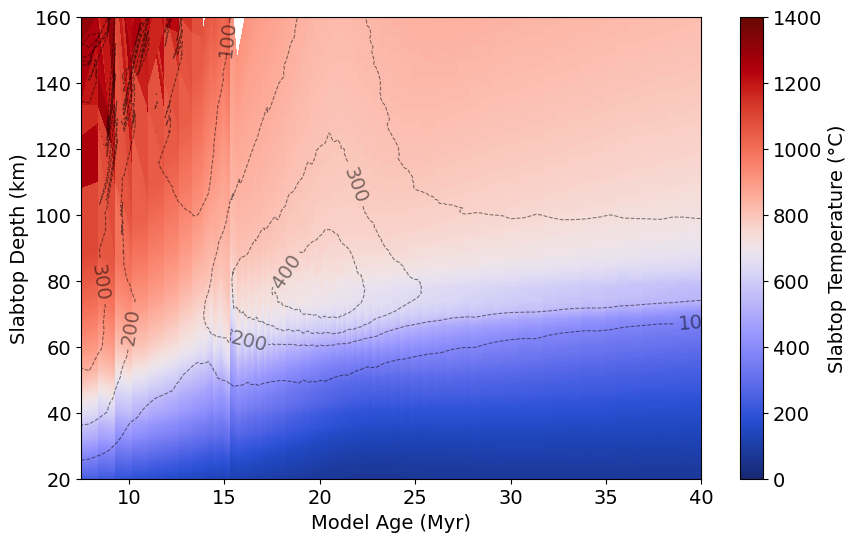

In [67]:
##graph to verify things are going ok. . . contour plot of slab temperature as a function of age on the X-axis
##and pressure on the Y-axis

##the first two chunks of code read in my colormap and normalize it. the third chunk creates the figure.
plt.rcParams.update({'font.size': 14})
plt.subplots(figsize=[10,6])
fluxmap = pd.read_csv("fluxmap.cpt", header=None)
fluxmap=fluxmap.to_numpy()
fluxmap_2=np.zeros((64,4))
fluxmap_2[:,0:3]=fluxmap[:,0:3]
fluxmap_2[:,3]=1

norm_temp=plt.Normalize(0,1400)
norm_pressure=plt.Normalize(0,8)
cmap=cm.get_cmap('cet_diverging_bwr_20_95_c54')

plt.pcolormesh(age,data_mat_norm[0,1,:,:],data_mat_norm[0,4,:,:], cmap=cmap, norm=norm_temp)
plt.ylim(20,160)
plt.xlim(7.5,40)
plt.colorbar(label='Slabtop Temperature (\u00b0C)')
plt.xlabel('Model Age (Myr)')
plt.ylabel('Slabtop Depth (km)')
plt.savefig("T_var.png")
CS=plt.contour(age,data_mat_norm[0,1,:,:],data_mat_norm[0,4,:,:]-data_mat_norm[1,4,:,:], levels=[100,200,300,400,500,600],colors='black',linewidths=0.75,linestyles='--',alpha=0.5)
CL=plt.clabel(CS)
#plt.savefig('holt4e20/f1.pdf')
plt.show()

(0.0, 5.0)

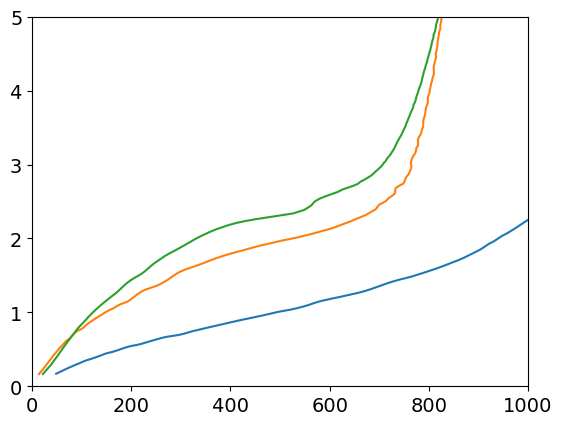

In [68]:
plt.plot(array2[3,0,0,:],array2[2,0,0,:],zorder=1)
plt.plot(array2[3,0,28,:],array2[2,0,28,:],zorder=1)
plt.plot(array2[3,0,59,:],array2[2,0,59,:],zorder=1)
plt.xlim(0,1000)
plt.ylim(0,5)
#plt.savefig('4e20_slabtop.pdf')

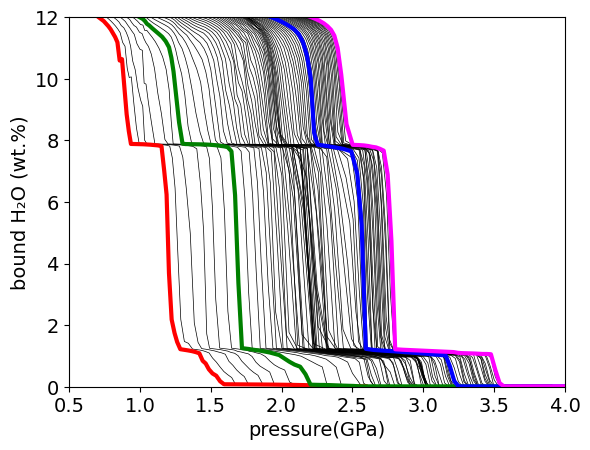

In [69]:
plt.plot(array2[2,0,0:75,:].T,wedge_out[0,0,0:75,:].T,linewidth=0.5,c='black')
plt.plot(array2[2,0,0,:],wedge_out[0,0,0,:], linewidth=3,c='red')
plt.plot(array2[2,0,6,:],wedge_out[0,0,6,:],linewidth=3,c='green')
plt.plot(array2[2,0,53,:],wedge_out[0,0,53,:],linewidth=3,c='blue')
plt.plot(array2[2,0,75,:],wedge_out[0,0,75,:],linewidth=3,c='magenta')
plt.xlim(0.5,4)
plt.ylim(0,12)
plt.ylabel('bound H\u2082O (wt.%)')
plt.xlabel('pressure(GPa)')
#plt.savefig('holt4e20/H2O_vs_P_wedge_serp.pdf')
plt.show()


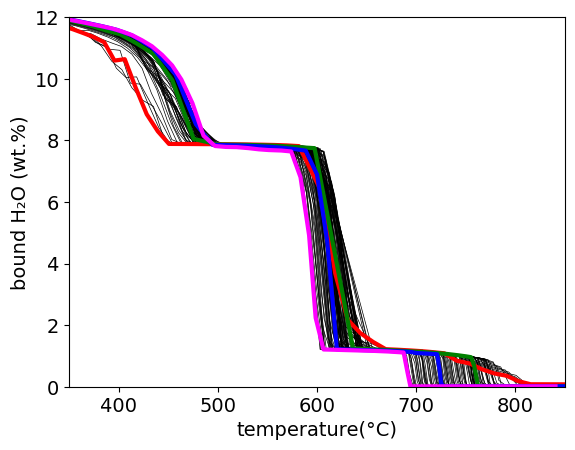

In [70]:
plt.plot(array2[3,0,:,:].T,wedge_out[0,0,:,:].T,linewidth=0.5,c='black')
plt.plot(array2[3,0,0,:],wedge_out[0,0,0,:], linewidth=3,c='red')
plt.plot(array2[3,0,29,:],wedge_out[0,0,29,:],linewidth=3,c='green')
plt.plot(array2[3,0,75,:],wedge_out[0,0,75,:],linewidth=3,c='blue')
plt.plot(array2[3,0,106,:],wedge_out[0,0,106,:],linewidth=3,c='magenta')
plt.xlim(350,850)
plt.ylim(0,12)
plt.ylabel('bound H\u2082O (wt.%)')
plt.xlabel('temperature(\u00b0C)')
#plt.savefig('holt4e20/H2O_vs_T_wedge_serp.pdf')
plt.show()


In [71]:
D=np.arange(0,10.1,0.1)
D=D.reshape(D.shape[0],-1)
D=np.repeat(D,even_inc,axis=1)

C:\Users\epste\AppData\Local\Temp\ipykernel_22668\3960261260.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


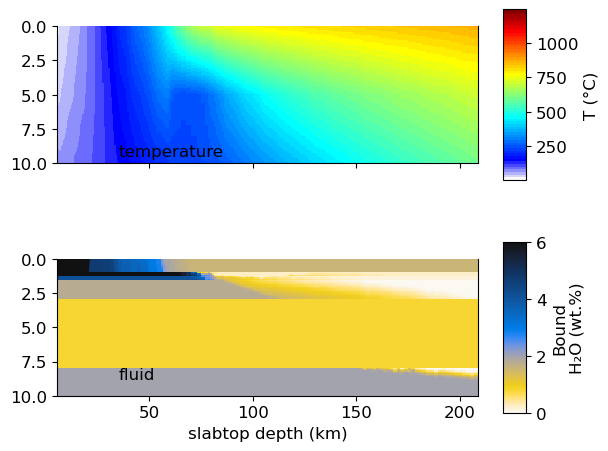

In [72]:
agestep=35

agind=agestep-8
xlow=np.where(xrange==np.nanmin(array2[0,:,agind,:]))[0][0]
xhigh=np.where(xrange==np.nanmax(array2[0,:,agind,:]))[0][0]

fluxmap = pd.read_csv("fluxmap.cpt", header=None)
fluxmap=fluxmap.to_numpy()
fluxmap_2=np.zeros((64,4))
fluxmap_2[:,0:3]=fluxmap[:,0:3]
fluxmap_2[:,3]=1

norm_temp=plt.Normalize(0,1250)
norm_dens=plt.Normalize(2850,3700)
norm_fluid=plt.Normalize(0,6)

cmap=ListedColormap(fluxmap_2)

cmap_new=cm.get_cmap('cet_linear_protanopic_deuteranopic_kbw_5_98_c40_r')

div_cmap=plt.cm.get_cmap('seismic')   ##good colormap for diverging datasets, blue=low, red=high
div_cmap_rev=div_cmap.reversed()      ##same as above but reversed, red=low, blue=high

plt.rcParams.update({'font.size': 12})
fig, axs=plt.subplots(2,1)
plt.subplots_adjust(hspace=0.7)
ax1=axs[0]
ax2=axs[1]

t_plot=ax1.pcolormesh(array2[1,0,agind,xlow:xhigh],D[:,xlow:xhigh],array2[3,:,agind,xlow:xhigh], cmap=cmap, norm=norm_temp)
fig.colorbar(t_plot, ax=ax1, fraction=0.1, aspect=7.5, ticks=[250,500,750,1000], shrink=1.25, label='T (\u00b0C)')
ax1.text(35,9.5,'temperature')
ax1.spines["top"].set_color("none")
ax1.axes.xaxis.set_ticklabels([])

fl_plot=ax2.pcolormesh(array2[1,0,agind,xlow:xhigh],D[:,xlow:xhigh],ppx_out[2,:,agind,xlow:xhigh], cmap=cmap_new, norm=norm_fluid)
fig.colorbar(fl_plot, ax=ax2, fraction=0.1, aspect=7.5, ticks=[0,2,4,6], shrink=1.25, label='Bound\nH\u2082O (wt.%)')
ax2.text(35,8.8,'fluid')
ax2.spines["top"].set_color("none")
#ax3.axes.xaxis.set_ticklabels([])


ax2.set_xlabel("slabtop depth (km)")
#ax1.set_ylabel("depth from interface (km)")
ax1.set_ylim(10, 0)
ax2.set_ylim(10, 0)

#plt.savefig("wedge_PT/figures/slab_bound_h2o_32.1myr_no_sed.pdf")
fig.show()

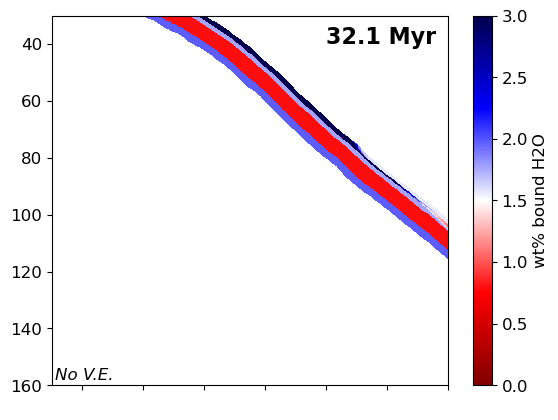

In [73]:
##another test plot, this time plotting Kg H2O liberated for a specific time slice
agestep=85

agind=agestep-8
xlow=np.where(xrange==np.nanmin(array2[0,:,agind,:]))[0][0]
xhigh=np.where(xrange==np.nanmax(array2[0,:,agind,:]))[0][0]

fluxmap = pd.read_csv("fluxmap.cpt", header=None)
fluxmap=fluxmap.to_numpy()
fluxmap_2=np.zeros((64,4))
fluxmap_2[:,0:3]=fluxmap[:,0:3]
fluxmap_2[:,3]=1
fluxmap_rev=np.flipud(fluxmap_2)

norm_temp=plt.Normalize(0,3)
norm_melt=plt.Normalize(0,3)
cmap=ListedColormap(fluxmap_2)
cmap_rev=ListedColormap(fluxmap_rev)

div_cmap=plt.cm.get_cmap('seismic')   ##good colormap for diverging datasets, blue=low, red=high
div_cmap_rev=div_cmap.reversed()      ##same as above but reversed, red=low, blue=high


plt.pcolormesh(array2[0,:,agind,xlow:xhigh],array2[1,:,agind,xlow:xhigh],ppx_out[2,:,agind,xlow:xhigh], cmap=div_cmap_rev, norm=norm_temp)
plt.ylim(160,30)
plt.xlim(6590,6720)
plt.colorbar(label='wt% bound H2O')
#plt.xlabel('Distance from model edge (km)')
#plt.ylabel('Depth (km)')
plt.xticks(color='w')
#plt.suptitle('Subduction age = 5.6 Myr')
#plt.title('Convergence = 2.777 cm/yr')
plt.text(6591,158,'No V.E.',style='italic')
plt.text(6680,40,'32.1 Myr',fontsize=16,fontweight='bold')
#plt.savefig("wedge_PT/figures/bound_h2o_32.1myr.png")
plt.show()

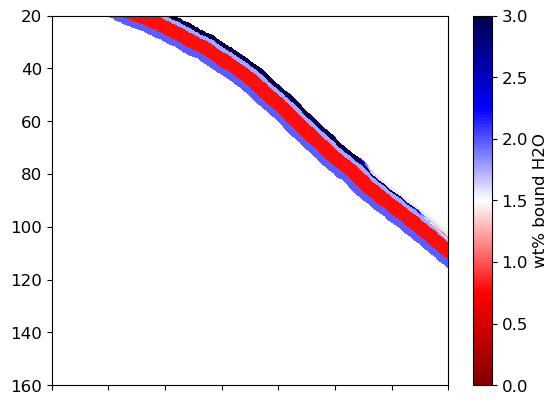

In [74]:
##another test plot, this time plotting Kg H2O liberated for a specific time slice
agestep=85

agind=agestep-8
xlow=np.where(xrange==np.nanmin(array2[0,:,agind,:]))[0][0]
xhigh=np.where(xrange==np.nanmax(array2[0,:,agind,:]))[0][0]

fluxmap = pd.read_csv("fluxmap.cpt", header=None)
fluxmap=fluxmap.to_numpy()
fluxmap_2=np.zeros((64,4))
fluxmap_2[:,0:3]=fluxmap[:,0:3]
fluxmap_2[:,3]=1
fluxmap_rev=np.flipud(fluxmap_2)

norm_temp=plt.Normalize(0,3)
norm_melt=plt.Normalize(0,3)
cmap=ListedColormap(fluxmap_2)
cmap_rev=ListedColormap(fluxmap_rev)

div_cmap=plt.cm.get_cmap('seismic')   ##good colormap for diverging datasets, blue=low, red=high
div_cmap_rev=div_cmap.reversed()      ##same as above but reversed, red=low, blue=high


plt.pcolormesh(array2[0,:,agind,xlow:xhigh],array2[1,:,agind,xlow:xhigh],ppx_out[2,:,agind,xlow:xhigh], cmap=div_cmap_rev, norm=norm_temp)
plt.ylim(160,20)
plt.xlim(6580,6720)
plt.colorbar(label='wt% bound H2O')
#plt.xlabel('Distance from model edge (km)')
#plt.ylabel('Depth (km)')
plt.xticks(color='w')
#plt.suptitle('Subduction age = 5.6 Myr')
#plt.title('Convergence = 2.777 cm/yr')
#plt.text(6591,158,'No V.E.',style='italic')
#plt.text(6680,40,'32.1 Myr',fontsize=16,fontweight='bold')
#plt.savefig("wedge_PT/figures/bound_h2o_32.1myr_sed.pdf")
plt.show()

C:\Users\epste\anaconda3\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


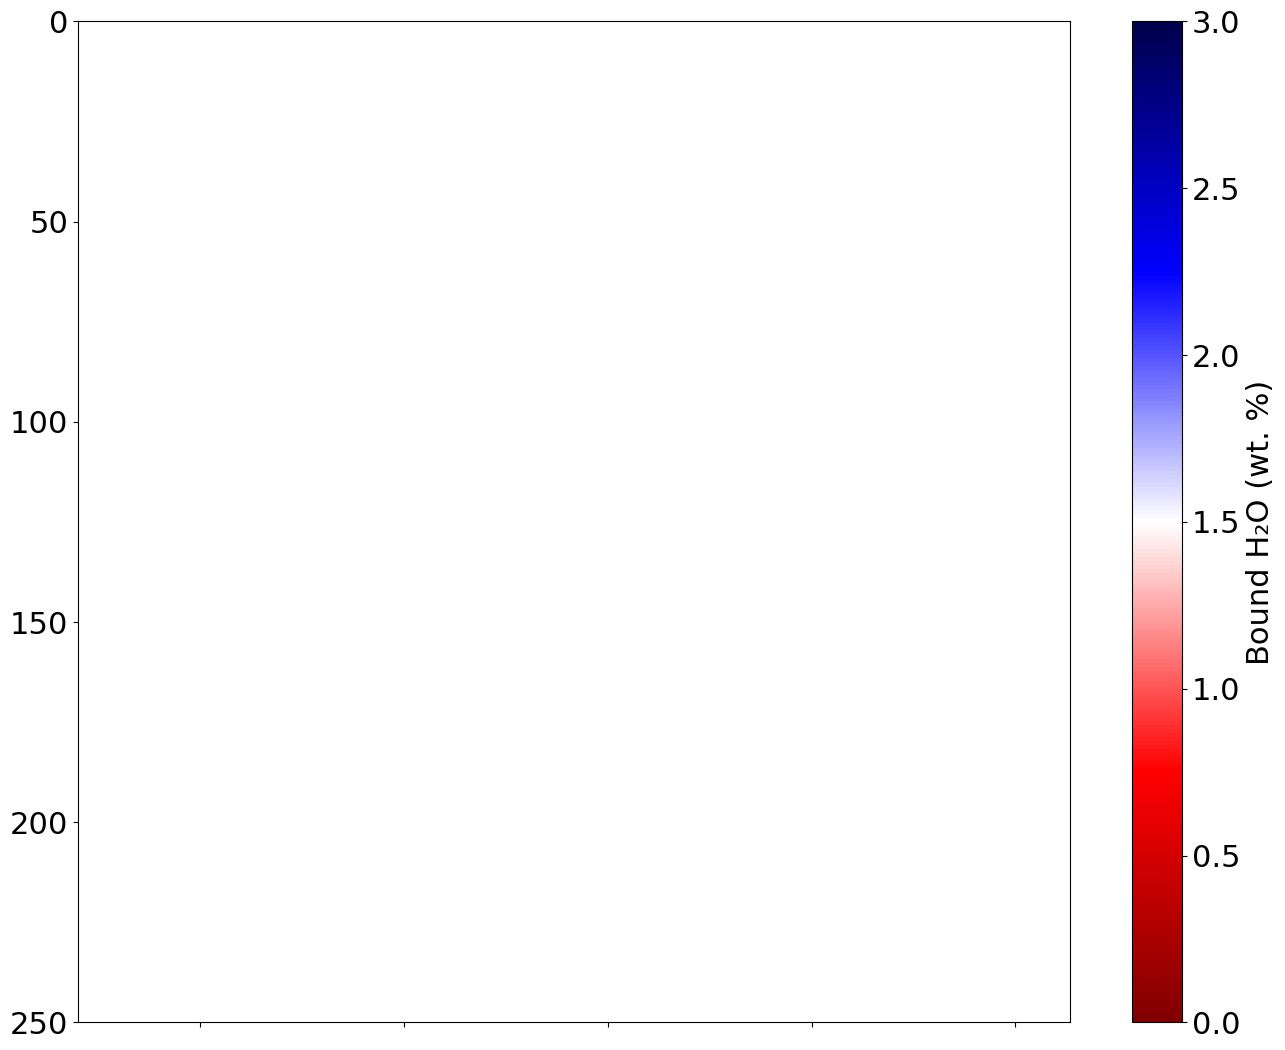

In [75]:
##Creates animations through time of slab properties with a moving X-axis. Approximately a 1:1 X:Y scale. For any new
##animation the colorbar must be reset both in terms of which one and in terms of range. 
from matplotlib.animation import FuncAnimation
plt.rcParams.update({'font.size': 22})
agestep=8
agind=agestep-8

xlow=np.where(xrange==np.nanmin(array2[0,:,agind,:]))[0][0]
xhigh=np.where(xrange==np.nanmax(array2[0,:,agind,:]))[0][0]

xstart=m.floor(np.nanmin(array2[0,:,i,:]))
xend=m.ceil(np.nanmax(array2[0,:,i,:]))

label='time = {} Ma'                    ##allows for a resetting label with animation
sublab='convergence = {} cm/yr'         ##allows for a resetting sublabel with animation

##readin my colormap, very useful if you dont want low or high values to be shaded
fluxmap = pd.read_csv("fluxmap.cpt", header=None)
fluxmap=fluxmap.to_numpy()
fluxmap_2=np.zeros((64,4))
fluxmap_2[:,0:3]=fluxmap[:,0:3]
fluxmap_2[:,3]=1
fluxmap_rev=np.flipud(fluxmap_2)

norm_temp=plt.Normalize(0,10)        ##range of values to be shaded with low values being a tranparent gray
norm_rev=plt.Normalize(0,3)          ##range of values to be shaded with high values being a transparent gray
cmap=ListedColormap(fluxmap_2)
cmap_rev=ListedColormap(fluxmap_rev)

div_cmap=plt.cm.get_cmap('seismic')   ##good colormap for diverging datasets, blue=low, red=high
div_cmap_rev=div_cmap.reversed()      ##same as above but reversed, red=low, blue=high

fig, ax=plt.subplots(figsize=[16,13]) ##sets figure size, close to 1:1
ax.set_xlim(xstart,xend+250)
ax.set_ylim(250,0)
ax.axes.xaxis.set_ticklabels([])
x_data=array2[0,:,agind,xlow:xhigh]
y_data=array2[1,:,agind,xlow:xhigh]
z_data=ppx_out[2,:,agind,xlow:xhigh]


t_plot=ax.pcolormesh(x_data, y_data, z_data, cmap=div_cmap_rev, norm=norm_rev)
fig.colorbar(t_plot, label='Bound H\u2082O (wt. %)')

##animation function. Needs to redefine X,Y,Z data, X, Y axes and labels, and call the pcolormesh funtion every time
def animat(i):
    xlow=np.where(xrange==np.nanmin(array2[0,:,i,:]))[0][0]
    xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0]
    
    k=age[i,0]
    kk=convergence[i,0]
    
    xstart=m.floor(np.nanmin(array2[0,:,i,:]))
    xend=m.ceil(np.nanmax(array2[0,:,i,:]))
    
    x_data=array2[0,:,i,xlow:xhigh]
    y_data=array2[1,:,i,xlow:xhigh]
    z_data=ppx_out[2,:,i,xlow:xhigh]
    
    ax.clear()
    
    ax.set_xlim(xstart,xstart+250)
    ax.set_ylim(250,0)
    fig.suptitle(label.format(k))
    ax.set_title(sublab.format(kk))
    ax.axes.xaxis.set_ticklabels([])
    ax.set_ylabel('depth (km)')
    #t_plot.set_ydata(y_data)
    t_plot=ax.pcolormesh(x_data, y_data, z_data, cmap=div_cmap_rev, norm=norm_rev)
    #t_plot=ax.pcolormesh(x_data, y_data, z_data, cmap=cmap, norm=norm_temp)
    return t_plot,

anim = FuncAnimation(fig, func=animat, frames=np.arange(0,30), interval=2000, repeat_delay=2000)


plt.show()
#anim.save("wedge_PT/h2o_nosed_slow.gif") #cannot see figure in notebook, need to save to gif.

In [76]:
print(np.where(wedge_out[0,0,0,:]<=.3)[0][0])

1035


In [77]:
d100=np.zeros((idx_len,))
d300=np.zeros((idx_len,))
d625=np.zeros((idx_len,))
d700=np.zeros((idx_len,))
d_i_200=np.zeros((idx_len,))
dbrc=np.zeros((idx_len,))
dant=np.zeros((idx_len,))
dchl=np.zeros((idx_len,))
dmelt=np.empty((idx_len,))
dmelt[:]=np.nan

for i in range(0,idx_len):
    d100[i,]=array2[1,0,i,np.where(array2[3,0,i,:]>=100)[0][0]]
    d300[i,]=array2[1,0,i,np.where(array2[3,0,i,:]>=300)[0][0]]
    d625[i,]=array2[1,0,i,np.where(array2[3,0,i,:]>=625)[0][0]]
    d700[i,]=array2[1,0,i,np.where(array2[3,0,i,:]>=700)[0][0]]
    d_i_200[i,]=array2[1,50,i,np.where(array2[3,50,i,:]>=200)[0][0]]
    dbrc[i,]=array2[1,0,i,np.where(wedge_out[0,0,i,:]<=8)[0][0]]
    dant[i,]=array2[1,0,i,np.where(wedge_out[0,0,i,:]<=4)[0][0]]
    dchl[i,]=array2[1,0,i,np.where(wedge_out[0,0,i,:]<=1)[0][0]]
    dmelt_i=np.where(array2[2,0,i,:]>=1.75)[0][0]
    if array2[3,0,i,dmelt_i]>=700:
        dmelt[i,]=array2[1,0,i,np.where(array2[3,0,i,:]>=700)[0][0]]

In [78]:
age2=pd.read_csv('holt4e20/age_convergence.txt', header=None, usecols=[1], delim_whitespace=True)
age2=age2.to_numpy()
##creates 2 array of ages for use in contour plotting
age2=np.repeat(age2[8:idx_len+8],even_inc,axis=1)

In [79]:
map_fl_mass=np.zeros((idx_len,even_inc))
#map_fl_mass[:]=np.nan
Y_map=array2[0,0,:,:]
Y_map=np.nan_to_num(Y_map,nan=0)

In [80]:
map_fl_mass=np.zeros((idx_len,even_inc))
#map_fl_mass[:]=np.nan
depth_map=array2[1,0,:,:]
depth_map=np.nan_to_num(depth_map,nan=0)

In [81]:
print(map_fl_mass.shape)

(107, 1107)


In [82]:
#sed_fl_mass=np.zeros((idx_len,even_inc))
#morb_fl_mass=np.zeros((idx_len,even_inc))
#gab_fl_mass=np.zeros((idx_len,even_inc))
#serp_fl_mass=np.zeros((idx_len,even_inc))

In [83]:
for i in range(0,idx_len):
    xlow=np.where(xrange==np.nanmin(array2[0,:,i,:]))[0][0]
    xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0]
    t_i=np.subtract(array2[1,100,i,xlow:xhigh],array2[1,0,i,xlow:xhigh])*10
    #t_i_sed=np.subtract(array2[1,10,i,xlow:xhigh],array2[1,0,i,xlow:xhigh])*10
    #t_i_morb=np.subtract(array2[1,30,i,xlow:xhigh],array2[1,11,i,xlow:xhigh])*10
    #t_i_gab=np.subtract(array2[1,80,i,xlow:xhigh],array2[1,31,i,xlow:xhigh])*10
    #t_i_serp=np.subtract(array2[1,100,i,xlow:xhigh],array2[1,81,i,xlow:xhigh])*10
    fluid_col=np.sum(ppx_out[6,0:thk_steps+1,i,xlow:xhigh],axis=0)
    #fluid_sed=np.sum(ppx_out[6,0:11,i,xlow:xhigh],axis=0)
    #fluid_morb=np.sum(ppx_out[6,11:31,i,xlow:xhigh],axis=0)
    #fluid_gab=np.sum(ppx_out[6,31:81,i,xlow:xhigh],axis=0)
    #fluid_serp=np.sum(ppx_out[6,81:101,i,xlow:xhigh],axis=0)
    map_fl_mass[i,xlow:xhigh]=np.multiply(fluid_col,t_i)
    #sed_fl_mass[i,xlow:xhigh]=np.multiply(fluid_sed,t_i_sed)
    #morb_fl_mass[i,xlow:xhigh]=np.multiply(fluid_morb,t_i_morb)
    #gab_fl_mass[i,xlow:xhigh]=np.multiply(fluid_gab,t_i_gab)
    #serp_fl_mass[i,xlow:xhigh]=np.multiply(fluid_serp,t_i_serp)
    Y_map[i,0:xlow]=array2[0,0,i,xlow]
    Y_map[i,xhigh:even_inc]=array2[0,0,i,xhigh]
    

In [84]:
for i in range(0,idx_len):
    xlow=np.where(xrange==np.nanmin(array2[0,:,i,:]))[0][0]
    xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0]
    t_i=np.subtract(array2[1,100,i,xlow:xhigh],array2[1,0,i,xlow:xhigh])*10
    fluid_col=np.sum(ppx_out[6,0:thk_steps+1,i,xlow:xhigh],axis=0)
    map_fl_mass[i,xlow:xhigh]=np.multiply(fluid_col,t_i)
    depth_map[i,0:xlow]=array2[1,0,i,xlow]
    depth_map[i,xhigh:even_inc]=array2[1,0,i,xhigh]

In [85]:
new_rainbow=cc.rainbow_bgyrm_35_85_c69
new_rainbow[0]='#FFFFFF'
cmap2=ListedColormap(new_rainbow)
cmap2_rev=cmap2.reversed()

In [86]:
dip_rad=np.empty((idx_len,even_inc))
dip_rad[:]=np.nan
delta_depth=np.empty((idx_len,even_inc))
delta_depth[:]=np.nan
for i in range(0,idx_len):
    xlow=np.where(xrange==np.nanmin(array2[0,:,i,:]))[0][0]
    xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0]
    for j in range(xlow+1,xhigh+1):
        dip_rad[i,j]=m.atan(array2[1,0,i,j]-array2[1,0,i,j-1])
        delta_depth[i,j]=abs(array2[1,0,i,j]-array2[1,0,i,j-1])
    dip_rad[i,xlow]=dip_rad[i,xlow+1]
app_sr=np.multiply(np.cos(dip_rad),convergence)/100

In [87]:
map_fl_flux=np.zeros((idx_len,even_inc))
#sed_fl_flux=np.zeros((idx_len,even_inc))
#morb_fl_flux=np.zeros((idx_len,even_inc))
#gab_fl_flux=np.zeros((idx_len,even_inc))
#serp_fl_flux=np.zeros((idx_len,even_inc))
for i in range(0,idx_len):
    xlow=np.where(xrange==np.nanmin(array2[0,:,i,:]))[0][0]
    xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0]
    map_fl_flux[i,xlow:xhigh]=np.multiply(map_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])
    #sed_fl_flux[i,xlow:xhigh]=np.multiply(sed_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])
    #morb_fl_flux[i,xlow:xhigh]=np.multiply(morb_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])
    #gab_fl_flux[i,xlow:xhigh]=np.multiply(gab_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])
    #serp_fl_flux[i,xlow:xhigh]=np.multiply(serp_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])
    Y_map[i,0:xlow]=array2[0,0,i,xlow]
    Y_map[i,xhigh:even_inc]=array2[0,0,i,xhigh]

In [88]:
devol_out=np.zeros((3,107,1107))
devol_out[0,:,:]=Y_map
devol_out[1,:,:]=depth_map
devol_out[2,:,:]=map_fl_flux

In [89]:
map_fl_flux=np.zeros((idx_len,even_inc))
for i in range(0,idx_len):
    xlow=np.where(xrange==np.nanmin(array2[0,:,i,:]))[0][0]
    xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0]
    map_fl_flux[i,xlow:xhigh]=np.multiply(map_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])
    depth_map[i,0:xlow]=array2[1,0,i,xlow]
    depth_map[i,xhigh:even_inc]=array2[1,0,i,xhigh]

In [90]:
forearc_flux=np.zeros((idx_len,even_inc))
for i in range(0,idx_len):
    xlow=np.where(array2[1,0,i,:]>=30)[0][0]
    if np.nanmax(array2[1,0,i,:])>80:
        xhigh=np.where(array2[1,0,i,:]>=80)[0][0]
    else:
        xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0] 
    forearc_flux[i,xlow:xhigh]=np.multiply(map_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])

In [91]:
forearc_flux_delt=np.zeros((idx_len,even_inc))
for i in range(0,idx_len):
    xlow=np.where(array2[1,0,i,:]>=30)[0][0]
    if np.nanmax(array2[1,0,i,:])>80:
        if dchl[i]<=80:
            xhigh=np.where(array2[1,0,i,:]>=dchl[i])[0][0]
        else:
            xhigh=np.where(array2[1,0,i,:]>=80)[0][0]
    else:
        xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0] 
    forearc_flux_delt[i,xlow:xhigh]=np.multiply(map_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])

In [92]:
forearc_flux_delt_serp=np.zeros((idx_len,even_inc))
for i in range(0,idx_len):
    xlow=np.where(array2[1,0,i,:]>=30)[0][0]
    if np.nanmax(array2[1,0,i,:])>80:
        if dant[i]<=80:
            xhigh=np.where(array2[1,0,i,:]>=dant[i])[0][0]
        else:
            xhigh=np.where(array2[1,0,i,:]>=80)[0][0]
    else:
        xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0] 
    forearc_flux_delt_serp[i,xlow:xhigh]=np.multiply(map_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])

In [93]:
forearc_flux_delt_brc=np.zeros((idx_len,even_inc))
for i in range(0,idx_len):
    xlow=np.where(array2[1,0,i,:]>=30)[0][0]
    if np.nanmax(array2[1,0,i,:])>80:
        if dant[i]<=80:
            xhigh=np.where(array2[1,0,i,:]>=dbrc[i])[0][0]
        else:
            xhigh=np.where(array2[1,0,i,:]>=80)[0][0]
    else:
        xhigh=np.where(xrange==np.nanmax(array2[0,:,i,:]))[0][0] 
    forearc_flux_delt_brc[i,xlow:xhigh]=np.multiply(map_fl_mass[i,xlow:xhigh],app_sr[i,xlow:xhigh])

In [94]:
X_tri=np.reshape(age2,118449)
Y_tri=np.reshape(depth_map,118449)
Z_tri=np.reshape(map_fl_flux,118449)
log_Z_tri=np.log10(Z_tri)
log_Z_tri=np.nan_to_num(log_Z_tri,nan=0)

C:\Users\epste\AppData\Local\Temp\ipykernel_22668\3050215487.py:4: RuntimeWarning: divide by zero encountered in log10
  log_Z_tri=np.log10(Z_tri)


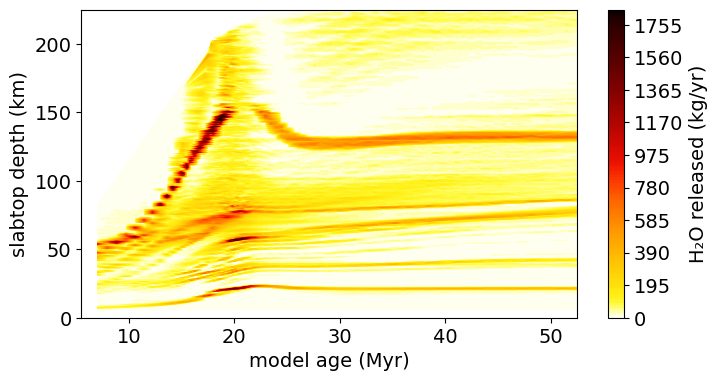

In [95]:
plt.rcParams.update({'font.size': 14})
plt.subplots(figsize=[8,4])
fluxmap = pd.read_csv("fluxmap.cpt", header=None)
fluxmap=fluxmap.to_numpy()
fluxmap_2=np.zeros((64,4))
fluxmap_2[:,0:3]=fluxmap[:,0:3]
fluxmap_2[:,3]=1

norm_temp=plt.Normalize(0,1500)
norm_pressure=plt.Normalize(0,8)
cmap=cm.get_cmap('cet_linear_kryw_0_100_c71_r')
#cmap=cmc.devon_r

plt.tricontourf(X_tri,Y_tri,Z_tri, cmap=cmap, levels=180)
plt.ylim(0,225)
plt.xlim(5.5,52.5)
plt.colorbar(label='H\u2082O released (kg/yr)')
plt.xlabel('model age (Myr)')
plt.ylabel('slabtop depth (km)')
#plt.plot(age2[:,0],dbrc,c='green',ls='-.')
#plt.text(30,210,'serpentine contribution',style='italic')
#plt.savefig("holt4e20/H2O_liberation_depth_sed_samescale.pdf")
plt.show()

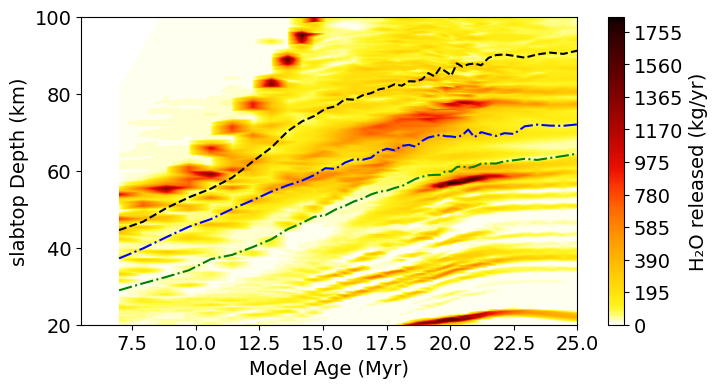

In [96]:
plt.rcParams.update({'font.size': 14})
plt.subplots(figsize=[8,4])
fluxmap = pd.read_csv("fluxmap.cpt", header=None)
fluxmap=fluxmap.to_numpy()
fluxmap_2=np.zeros((64,4))
fluxmap_2[:,0:3]=fluxmap[:,0:3]
fluxmap_2[:,3]=1

norm_temp=plt.Normalize(0,1500)
norm_pressure=plt.Normalize(0,8)
cmap=cm.get_cmap('cet_linear_kryw_0_100_c71_r')
#cmap=cmc.devon_r

plt.tricontourf(X_tri,Y_tri,Z_tri, cmap=cmap, levels=180)
plt.ylim(20,100)
plt.xlim(5.5,25)
plt.colorbar(label='H\u2082O released (kg/yr)')
plt.plot(age2[:,0],dchl,c='black',ls='--')
plt.plot(age2[:,0],dant,c='blue',ls='-.')
plt.plot(age2[:,0],dbrc,c='green',ls='-.')
plt.xlabel('Model Age (Myr)')
plt.ylabel('slabtop Depth (km)')
#plt.text(22.5,68,'625\u00b0C',style='italic',rotation=6,c='blue')
#plt.text(22.5,83,'700\u00b0C',style='italic',rotation=6)
#plt.text(30,210,'serpentine contribution',style='italic')
#plt.savefig("holt4e20/H2O_liberation_depth_sed_zoom_ant.pdf")
plt.show()

In [97]:
print(age2.shape)

(107, 1107)


In [98]:
forearc_tot=np.nansum(forearc_flux,axis=1)
forearc_delt_tot=np.nansum(forearc_flux_delt,axis=1)
forearc_delt_serp_tot=np.nansum(forearc_flux_delt_serp,axis=1)
forearc_delt_brc_tot=np.nansum(forearc_flux_delt_brc,axis=1)
map_fl_tot=np.nansum(map_fl_flux,axis=1)
print(forearc_delt_tot.T.shape)

(107,)


In [99]:
print(forearc_delt_tot)

[ 1735.48381806  1631.21477799  2040.69789813  2646.33295608
  3074.42858534  3605.03132349  4261.04435503  4623.70996831
  5405.8060028   6248.78263725  6228.72993584  6425.98519603
  6798.07226447  7426.13844     7532.30577578  7601.63865491
  7559.62131889  7659.42817538  8287.65982609  8251.35649402
  8511.97408643  8755.29690174  8888.28130653  9293.46255237
 10002.6439853   9976.29561013 10497.48910859 10625.49094765
 11504.10210422 10798.7466791  10992.13949968 10929.05867317
 10036.97534484  9022.74212281  8118.86054726  7193.79148083
  6431.37548764  5718.32333204  5023.35280628  4474.13103531
  4012.35529801  3716.61823767  3640.23550443  3509.68811691
  3512.29872608  3419.53429001  3384.61331521  3355.95273178
  3401.33095656  3379.9312388   3330.40291194  3341.82442615
  3123.38354756  2934.73930358  2933.39484881  2960.65213646
  2788.97212034  2840.27540026  2759.95674123  2690.50251118
  2700.88921307  2680.69614639  2633.84895636  2619.71565134
  2613.21034638  2590.02

In [100]:
print(dchl)

[ 44.57715735  46.74330713  50.29955475  53.10047345  55.34006536
  58.20921559  62.41447253  66.05198467  70.27875519  72.79901119
  74.21031187  76.10094751  76.7286485   78.59279338  78.4583442
  79.5877062   80.15466487  81.13269876  81.54763819  82.45829927
  82.07622768  83.24032052  83.1878749   83.72631632  85.36473964
  84.52487397  86.69260483  85.77629883  84.72151152  87.87826646
  87.02780632  87.62732828  87.84996184  87.38209867  89.30568664
  90.0447026   90.19805556  89.83876857  89.36622284  90.19801227
  90.68211214  90.34793295  91.26574266  91.67821964  91.95888028
  93.39686653  94.23579316  95.12807902  95.45567036  96.58073429
  97.04709121  97.19835462  97.73652551  98.47530926  98.45899436
  99.65772466 100.55867029 100.68307659 100.65319776 101.24097177
 101.71366759 102.6383302  102.83616443 102.63026464 102.89478256
 103.39933138 104.51939187 105.18586476 105.20133507 105.24374367
 105.45233948 106.17821391 106.21621874 107.20864134 107.41708502
 108.329834

In [101]:
#np.savetxt('Wedge_PT/forearc_delt_flux_4e20_no_sed_new.txt',forearc_delt_tot)

In [102]:
S_rate=convergence[:,0]/100
h2o_in=((rho_serp_i*h2o_serp*thk_serp)+(rho_morb_i*h2o_morb*thk_morb)+(rho_gab_i*h2o_gab*thk_gab)+(rho_sed_i*h2o_sed*thk_sed))*S_rate

In [103]:
efficiency=np.divide(map_fl_tot,h2o_in)
fa_efficiency=np.divide(forearc_delt_tot,h2o_in)
fa_serp_efficiency=np.divide(forearc_delt_serp_tot,h2o_in)
fa_brc_efficiency=np.divide(forearc_delt_brc_tot,h2o_in)

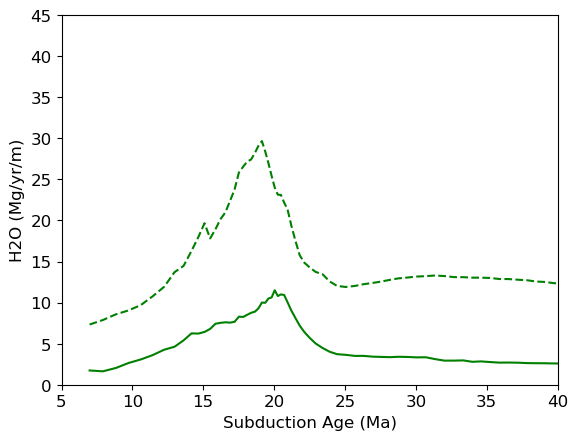

In [104]:
plt.rcParams.update({'font.size': 12})
#plt.plot(age2[:,0],h2o_in/1000, 'green',ls='dotted',label='subducted at trench')
#plt.plot(age2[:,0],map_fl_tot/1000, 'green', ls='--',label='total liberated by 200km depth')
plt.plot(age2[:,0],forearc_delt_tot/1000, 'green',label='total liberated in mantle wedge')
plt.plot(age2[:,0],map_fl_tot/1000, 'green',ls='--',label='total liberated in mantle wedge')
plt.xlabel('Subduction Age (Ma)')
plt.ylabel('H2O (Mg/yr/m)')
plt.xlim(5,40)
plt.ylim(0,45)
#plt.legend()
#plt.savefig("holt4e20/forearc_h2o_4e20_sed.pdf")
plt.show()


(0.0, 8.0)

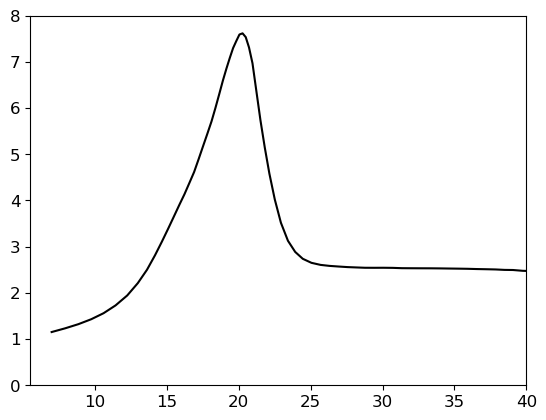

In [105]:
plt.plot(age2[:,0],S_rate*100, c='black')
plt.xlim(5.5,40)
plt.ylim(0,8)
#plt.savefig("wedge_pt/figures/convergence_4e20.pdf")

(0.0, 1000.0)

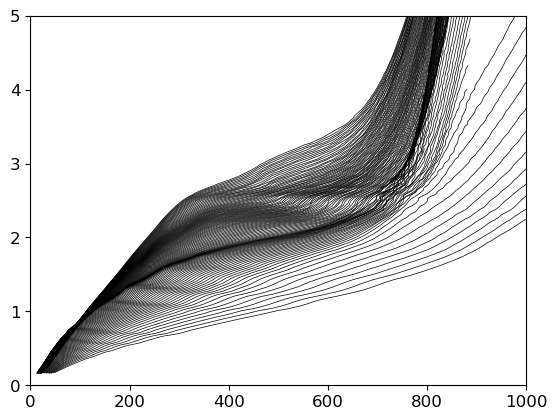

In [106]:
plt.plot(array2[3,0,:,:].T,array2[2,0,:,:].T, lw=0.5,c='black')
plt.ylim(0,5)
plt.xlim(0,1000)

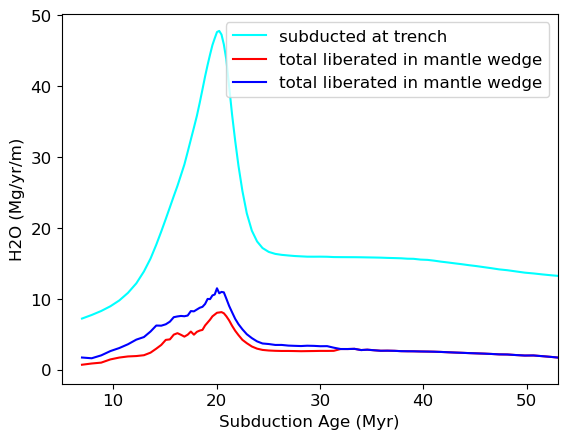

In [107]:
plt.rcParams.update({'font.size': 12})
plt.plot(age2[:,0],h2o_in/1000, 'cyan',label='subducted at trench')
plt.plot(age2[:,0],forearc_delt_serp_tot/1000, 'red', label='total liberated in mantle wedge')
plt.plot(age2[:,0],forearc_delt_tot/1000, 'blue', label='total liberated in mantle wedge')
plt.xlabel('Subduction Age (Myr)')
plt.ylabel('H2O (Mg/yr/m)')
plt.xlim(5,53)
plt.legend()
#plt.savefig("Total_h2o_2e20_forearc.pdf")
plt.show()


(30.0, 105.0)

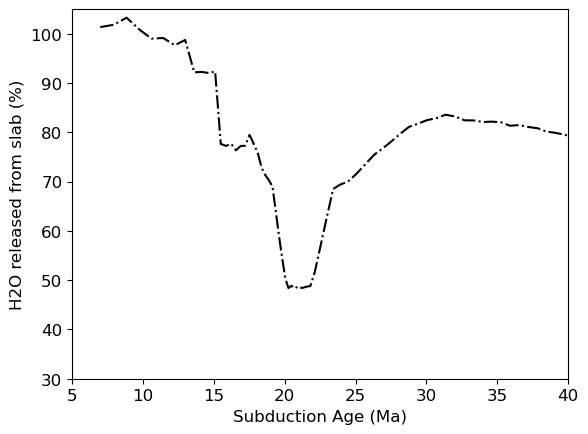

In [108]:
plt.rcParams.update({'font.size': 12})
plt.plot(age2[:,0],efficiency*100,'black',ls='-.',label='entire model range')
#plt.plot(age2[:,0],fa_efficiency*100,'red',ls='--',label='forearc release')
#plt.plot(age2[:,0],fa_serp_efficiency*100,'blue',label='forearc serp release')
plt.xlabel('Subduction Age (Ma)')
plt.ylabel('H2O released from slab (%)')
#plt.legend(loc='upper right')
plt.xlim(5,40)
plt.ylim(30,105)
#plt.savefig("holt4e20/full_recycling_efficiency_4e20_sed.pdf")

(0.0, 45.0)

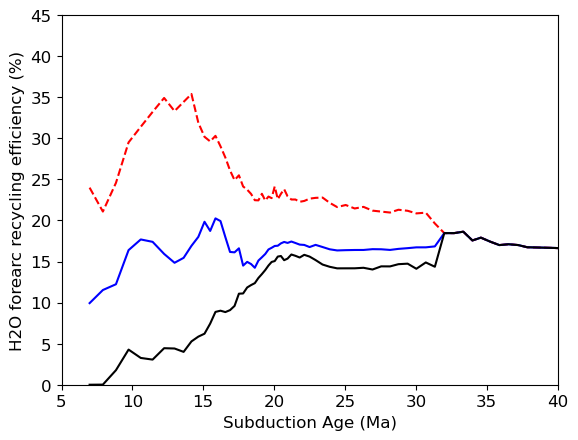

In [109]:
plt.rcParams.update({'font.size': 12})
plt.plot(age2[:,0],fa_efficiency*100,ls='--',c='red')
plt.plot(age2[:,0],fa_serp_efficiency*100,c='blue')
plt.plot(age2[:,0],fa_brc_efficiency*100,c='black')
plt.xlabel('Subduction Age (Ma)')
plt.ylabel('H2O forearc recycling efficiency (%)')
plt.xlim(5,40)
plt.ylim(0,45)
#plt.savefig("holt4e20/recycling_efficiency_forearc_4e20_sed.pdf")

In [110]:
print(age2.shape)

(107, 1107)


Text(0, 0.5, 'H2O released from slab (%)')

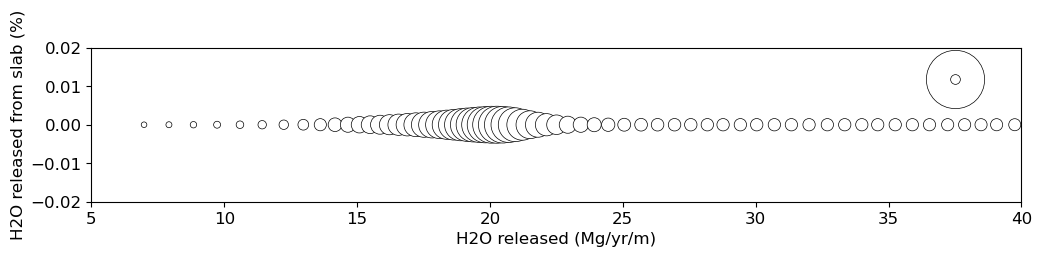

In [111]:
plt.rcParams.update({'font.size': 12})
plt.subplots(figsize=[12,2])
#cmap=cm.get_cmap('cet_linear_bgy_10_95_c74_r')
cmap=cm.get_cmap('cet_linear_tritanopic_krjcw_5_98_c46_r')
norm=plt.Normalize(5,55)
plt.scatter(age2[:,0],np.zeros((107,1)),c='white',norm=norm,cmap=cmap,s=(S_rate*350)**2,edgecolors='black',linewidths=0.5)
plt.scatter(37.5,0.012,c='white',norm=norm,cmap=cmap,s=(.12*350)**2,edgecolors='black',linewidths=0.5)
plt.scatter(37.5,0.012,c='white',norm=norm,cmap=cmap,s=(.02*350)**2,edgecolors='black',linewidths=0.5)
plt.xlim(5,40)
plt.ylim(-.02,.02)
#plt.colorbar(label='subduction age (Myr)')
#plt.plot(forearc_delt_tot/1000,fa_efficiency,lw=0.5,ls='dotted',c='black')
#plt.scatter(43,1,c='None',s=(.12*200)**2,edgecolors='black',linewidths=0.5)
#plt.scatter(43,1,c='None',s=(.02*200)**2,edgecolors='black',linewidths=0.5)
#plt.text(14.5,1.01,'5.6 Myr',style='italic',c='black',fontsize=10)
#plt.text(36.25,0.42,'11.8 Myr',style='italic',c='black',fontsize=10)
#plt.text(14,0.86,'32.1 Myr',style='italic',c='black',fontsize=10)
plt.xlabel('H2O released (Mg/yr/m)')
plt.ylabel('H2O released from slab (%)')
#plt.savefig("holt4e20/s_rate.pdf")

In [112]:
#np.savetxt('wedge_PT/2e20_sed_efficiency.txt',efficiency)

In [113]:
annual_flux=np.divide(map_fl_flux,delta_depth)/1000

C:\Users\epste\AppData\Local\Temp\ipykernel_22668\3861439630.py:1: RuntimeWarning: divide by zero encountered in true_divide
  annual_flux=np.divide(map_fl_flux,delta_depth)/1000


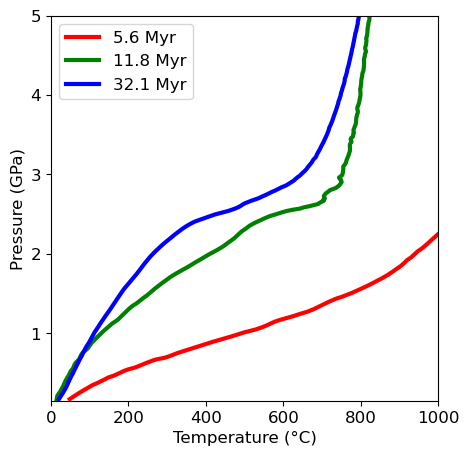

In [114]:
plt.subplots(figsize=[5,5])
#plt.plot(np.linspace(0,773,5),np.linspace(0,6),'yellow')
#plt.plot(data_mat_norm[0,4,:,:].T,data_mat_norm[0,3,:,:].T, 'black', lw=0.5)
plt.plot(data_mat_norm[0,4,0,:],data_mat_norm[0,3,0,:], 'red', lw=3, label='5.6 Myr')
#plt.plot(data_mat_norm[0,4,8,330:499],data_mat_norm[0,3,8,330:499], 'red', ls='--',lw=3)
plt.plot(data_mat_norm[0,4,27,:],data_mat_norm[0,3,35,:], 'green', lw=3, label='11.8 Myr')
plt.plot(data_mat_norm[0,4,77,:],data_mat_norm[0,3,85,:], 'blue', lw=3, label='32.1 Myr')
plt.ylim(0.15,5)
plt.xlim(0,1000)
plt.xlabel('Temperature (\u00b0C)')
plt.ylabel('Pressure (GPa)')
plt.legend()
#plt.savefig("wedge_PT/figures/forearc_PT.pdf")
plt.show()